In [1]:
%matplotlib inline

In [2]:
# add repo path
import sys
sys.path.append('/home/gautam_sisodia/gen-purpose-repo/')

In [3]:
import gym
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rl import frozenlake as fl

[2017-10-08 15:05:54,542] Making new env: FrozenLake-v0


In [13]:
print(plt.style.available)

['seaborn-poster', 'seaborn-notebook', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-dark', 'grayscale', 'seaborn-white', 'seaborn-talk', 'classic', 'fivethirtyeight', 'seaborn-dark-palette', 'seaborn-bright', 'bmh', 'ggplot', 'seaborn-colorblind', 'seaborn-ticks', 'seaborn-pastel', 'seaborn-muted', 'seaborn-paper', 'seaborn-whitegrid', 'dark_background']


In [14]:
plt.style.use('seaborn-darkgrid')

In [4]:
env = gym.make('FrozenLake-v0')
env.reset()
env.render()

[2017-10-08 15:05:54,561] Making new env: FrozenLake-v0



SFFF
FHFH
FFFH
HFFG


## General Stats
Gathering some general statistics about states from random actions

In [5]:
state_dict = False

In [6]:
state_dict, rand_game_df = fl.run_n_games(20000, fl.rand_strategy, state_dict)

100%|██████████| 20000/20000 [00:04<00:00, 4415.95it/s]


In [8]:
fl.print_game_stats(rand_game_df)

Total number of moves: 154606
Number of moves per game: 7.7303
Total number of games won: 285.0
Percentage of games won: 1.425


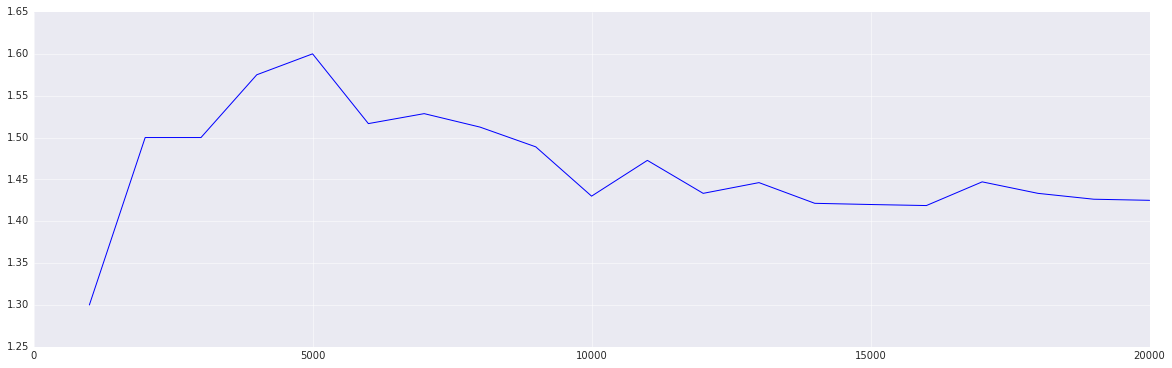

In [15]:
fl.plot_winning_percentage(rand_game_df)